#                                       CSE578 - Computer Vision
##                                          Assignment - 4


**> Name : Jeet Vora**

**> Roll No.: 2019701006**







<img src = '1.png' width="700" height="200">

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

**Loading CIFAR 100 Dataset**







In [0]:
# transform object to transform data in pytorch tensor and normalize the data mean/stddev for 3 channels (0.5,0.5,0.5)/(0.5,0.5,0.5)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Loading of training and testing data
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

# train and validation split
train, validation = torch.utils.data.random_split(trainset, [40000,10000])

trainloader = torch.utils.data.DataLoader(train, batch_size=4,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validation, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


Extracting ./data/cifar-100-python.tar.gz to ./data


Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
print('Train: ',len(trainloader))
print('Validation: ',len(validloader))
print('Test: ',len(testloader))

Train:  10000
Validation:  2500
Test:  2500


(3, 32, 32)


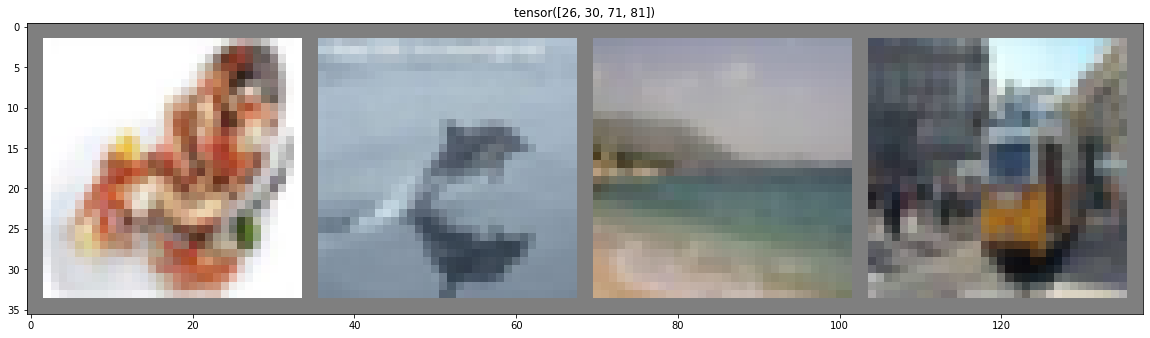

In [0]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.title(labels)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images[0].numpy().shape)
# show images
imshow(torchvision.utils.make_grid(images))

**CNN Model 1 : (2 CNN Layers and 3 FC layers)**

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(num_features = 6)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)   #Maxpooling reduces the size by kernel size. 30/2 = 16
        
        self.cnn2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(num_features = 16)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)    #Size now is 16/2 = 8
        
        #Flatten the feature maps. You have 16 feature mapsfrom cnn2. Each of the feature is of size 7*7 --> 16*7*7 = 784
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=300)   #Flattened image is fed into linear NN and reduced to half size
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(in_features=300, out_features=200)
        self.dropout = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(in_features=200, out_features=100)

        
    def forward(self,x):
        x = self.maxpool1(F.relu(self.batchnorm1(self.cnn1(x))))
        x = self.maxpool2(F.relu(self.batchnorm2(self.cnn2(x))))
        #print(x.shape)
        x = x.view(-1, 16 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

net = CNN()

In [0]:
def Train_and_Validate(loss_fn, optimizer, trainloader, validloader, train_length, validation_length):
    # Training the CNN
    num_epochs = 20
    
    # Define the lists to store the results of loss and accuracy
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []
    
    
    # Training
    
    for epoch in range(num_epochs): 
        #Reset these below variables to 0 at the begining of every epoch
        correct = 0
        iterations = 0
        iter_loss = 0.0
        
        net.train()                   # Put the network into training mode
        
        for i, data in enumerate(trainloader):
            
            # Convert torch tensor to Variable
            inputs, labels = data
    
            optimizer.zero_grad()            # Clear off the gradient
            outputs = net3(inputs)         
            loss = loss_fn(outputs, labels)  
            iter_loss += loss.item()       # Accumulate the loss
            loss.backward()                 # Backpropagation 
            optimizer.step()                # Update the weights
            
            # Record the correct predictions for training data 
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
            iterations += 1
        
        # Record the training loss
        train_loss.append(iter_loss/iterations)
        # Record the training accuracy
        train_accuracy.append((100 * correct / train_length))
        
        # Validation
        
        iter_loss = 0.0
        correct = 0
        iterations = 0
    
        net.eval()                    # Put the network into evaluation mode
        
        for i, data in enumerate(validloader):
            
            # Convert torch tensor to Variable
            inputs, labels = data
            
            outputs = net3(inputs)     
            loss = loss_fn(outputs, labels) # Calculate the loss
            iter_loss += loss.item()
            # Record the correct predictions for training data
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum()
            
            iterations += 1
    
        # Record the Testing loss
        valid_loss.append(iter_loss/iterations)
        # Record the Testing accuracy
        valid_accuracy.append((100 * correct / validation_length))
        
        print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Validation Loss: {:.3f}, Validation Accuracy: {:.3f}'.format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
    
    # Loss
    f = plt.figure(figsize=(10, 10))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    f = plt.figure(figsize=(10, 10))
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(valid_accuracy, label='Validation Accuracy')
    plt.legend()
    plt.show()

**Training without Dropout and BatchNorm**

Epoch 1/15, Training Loss: 1.771, Training Accuracy: 50.000, Validation Loss: 3.545, Validation Accuracy: 25.000
Epoch 2/15, Training Loss: 1.618, Training Accuracy: 54.000, Validation Loss: 3.918, Validation Accuracy: 25.000
Epoch 3/15, Training Loss: 1.502, Training Accuracy: 56.000, Validation Loss: 4.025, Validation Accuracy: 23.000
Epoch 4/15, Training Loss: 1.383, Training Accuracy: 60.000, Validation Loss: 4.239, Validation Accuracy: 24.000
Epoch 5/15, Training Loss: 1.288, Training Accuracy: 63.000, Validation Loss: 4.359, Validation Accuracy: 24.000
Epoch 6/15, Training Loss: 1.238, Training Accuracy: 64.000, Validation Loss: 4.499, Validation Accuracy: 22.000
Epoch 7/15, Training Loss: 1.180, Training Accuracy: 65.000, Validation Loss: 4.760, Validation Accuracy: 22.000
Epoch 8/15, Training Loss: 1.144, Training Accuracy: 67.000, Validation Loss: 5.178, Validation Accuracy: 21.000
Epoch 9/15, Training Loss: 1.113, Training Accuracy: 67.000, Validation Loss: 5.362, Validation 

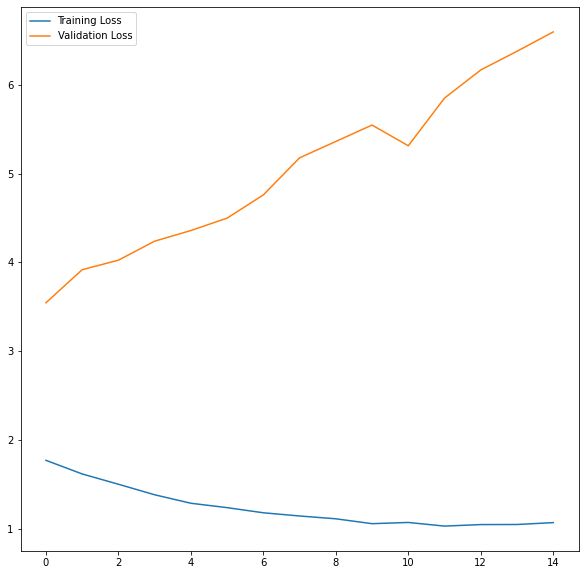

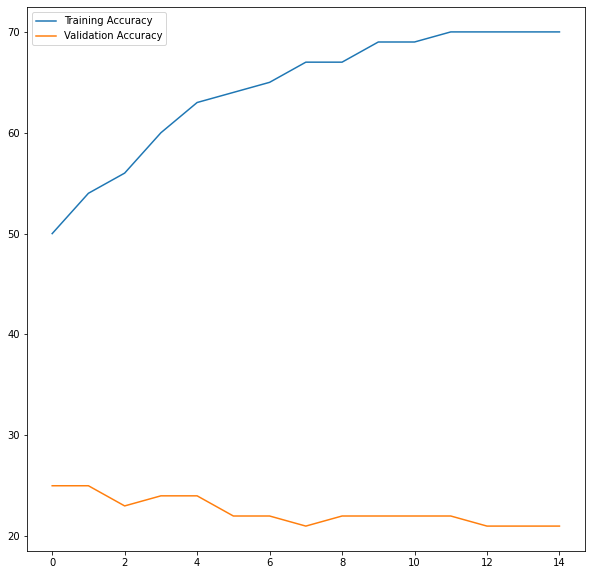

In [0]:
# without dropout and batchnorm
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
Train_and_Validate(loss_fn, optimizer, trainloader, validloader, len(train), len(validation))

**Training with BatchNorm and no Dropout**

Epoch 1/15, Training Loss: 3.974, Training Accuracy: 9.000, Validation Loss: 3.451, Validation Accuracy: 17.000
Epoch 2/15, Training Loss: 3.350, Training Accuracy: 19.000, Validation Loss: 3.113, Validation Accuracy: 23.000
Epoch 3/15, Training Loss: 3.033, Training Accuracy: 25.000, Validation Loss: 2.944, Validation Accuracy: 27.000
Epoch 4/15, Training Loss: 2.808, Training Accuracy: 29.000, Validation Loss: 2.860, Validation Accuracy: 29.000
Epoch 5/15, Training Loss: 2.628, Training Accuracy: 33.000, Validation Loss: 2.767, Validation Accuracy: 30.000
Epoch 6/15, Training Loss: 2.455, Training Accuracy: 36.000, Validation Loss: 2.764, Validation Accuracy: 31.000
Epoch 7/15, Training Loss: 2.309, Training Accuracy: 39.000, Validation Loss: 2.753, Validation Accuracy: 32.000
Epoch 8/15, Training Loss: 2.162, Training Accuracy: 42.000, Validation Loss: 2.811, Validation Accuracy: 32.000
Epoch 9/15, Training Loss: 2.019, Training Accuracy: 46.000, Validation Loss: 2.913, Validation A

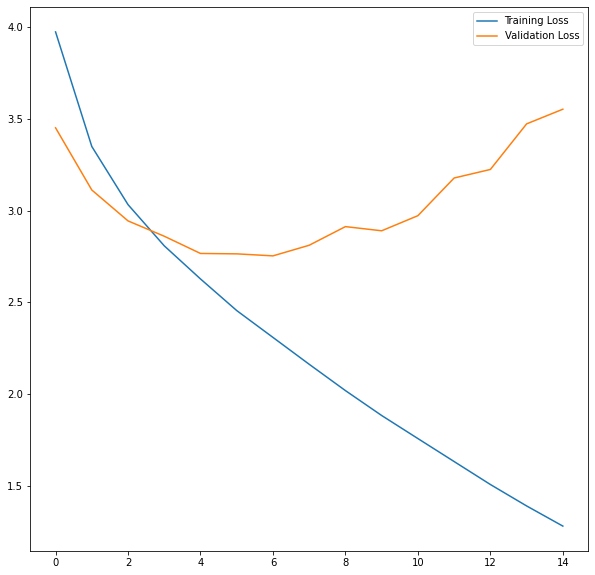

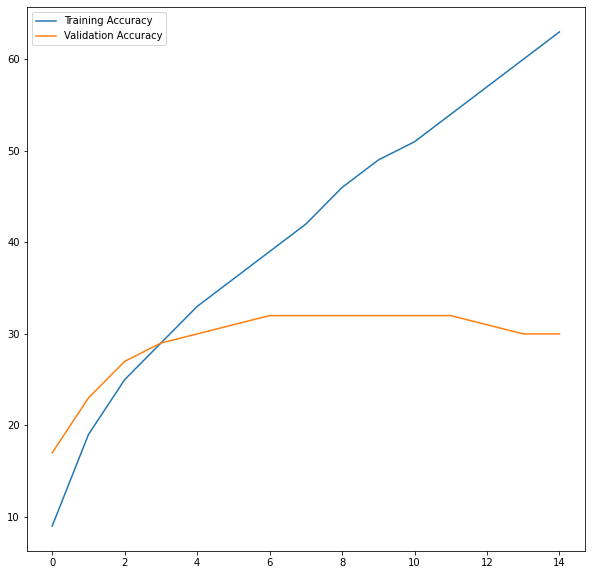

In [0]:
# with batchnnorm and no dropout
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
Train_and_Validate(loss_fn, optimizer, trainloader, validloader, len(train), len(validation))

**With Dropout and BatchNorm**

Epoch 1/15, Training Loss: 4.045, Training Accuracy: 8.000, Validation Loss: 3.551, Validation Accuracy: 14.000
Epoch 2/15, Training Loss: 3.543, Training Accuracy: 16.000, Validation Loss: 3.239, Validation Accuracy: 21.000
Epoch 3/15, Training Loss: 3.298, Training Accuracy: 20.000, Validation Loss: 3.039, Validation Accuracy: 25.000
Epoch 4/15, Training Loss: 3.106, Training Accuracy: 23.000, Validation Loss: 2.924, Validation Accuracy: 27.000
Epoch 5/15, Training Loss: 2.964, Training Accuracy: 26.000, Validation Loss: 2.850, Validation Accuracy: 28.000
Epoch 6/15, Training Loss: 2.842, Training Accuracy: 29.000, Validation Loss: 2.780, Validation Accuracy: 31.000
Epoch 7/15, Training Loss: 2.729, Training Accuracy: 31.000, Validation Loss: 2.760, Validation Accuracy: 31.000
Epoch 8/15, Training Loss: 2.632, Training Accuracy: 33.000, Validation Loss: 2.696, Validation Accuracy: 33.000
Epoch 9/15, Training Loss: 2.539, Training Accuracy: 35.000, Validation Loss: 2.670, Validation A

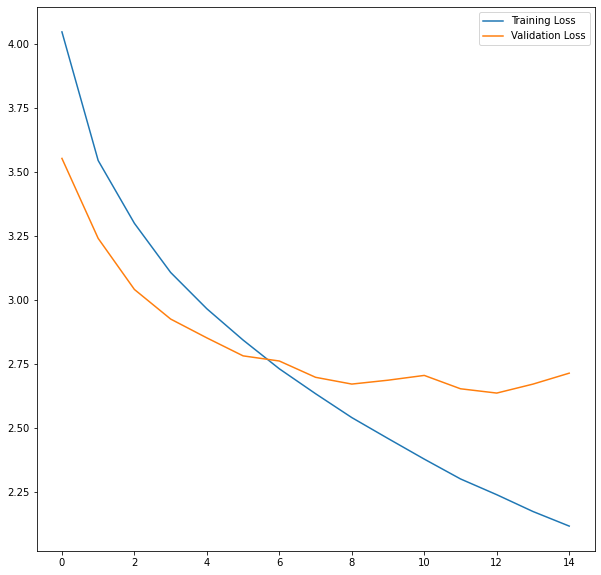

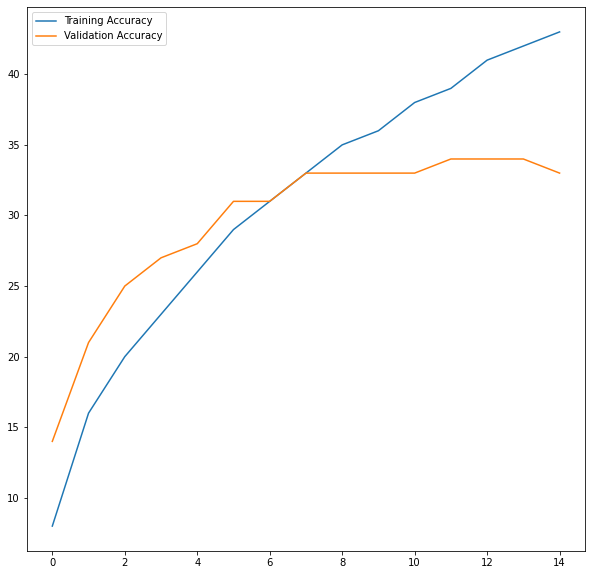

In [0]:
# with dropout and batchnorm
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
Train_and_Validate(loss_fn, optimizer, trainloader, validloader, len(train), len(validation))

**Low Learning Rate with both dropout and batchnorm**

Epoch 1/15, Training Loss: 4.527, Training Accuracy: 2.000, Validation Loss: 4.285, Validation Accuracy: 4.000
Epoch 2/15, Training Loss: 4.226, Training Accuracy: 5.000, Validation Loss: 3.944, Validation Accuracy: 8.000
Epoch 3/15, Training Loss: 3.984, Training Accuracy: 9.000, Validation Loss: 3.726, Validation Accuracy: 12.000
Epoch 4/15, Training Loss: 3.788, Training Accuracy: 11.000, Validation Loss: 3.542, Validation Accuracy: 16.000
Epoch 5/15, Training Loss: 3.638, Training Accuracy: 14.000, Validation Loss: 3.411, Validation Accuracy: 18.000
Epoch 6/15, Training Loss: 3.524, Training Accuracy: 16.000, Validation Loss: 3.321, Validation Accuracy: 19.000
Epoch 7/15, Training Loss: 3.423, Training Accuracy: 17.000, Validation Loss: 3.242, Validation Accuracy: 21.000
Epoch 8/15, Training Loss: 3.334, Training Accuracy: 19.000, Validation Loss: 3.150, Validation Accuracy: 23.000
Epoch 9/15, Training Loss: 3.249, Training Accuracy: 21.000, Validation Loss: 3.088, Validation Accur

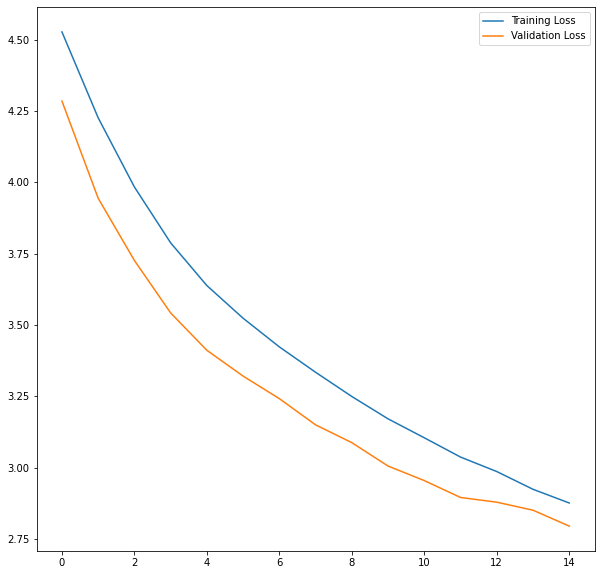

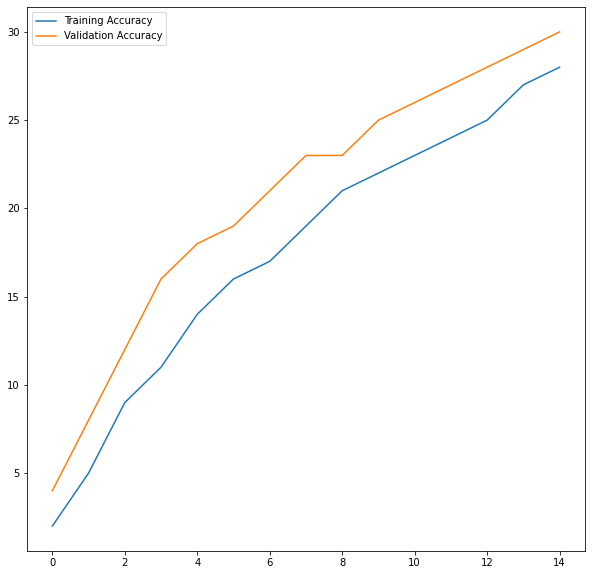

In [0]:
# with batchnorm and dropout and lower learning rate
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
Train_and_Validate(loss_fn, optimizer, trainloader, validloader, len(train), len(validation))

**CNN Model 2 : (2 CNN and 2 FC layer)**

In [0]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2,self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(num_features = 6)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)   #Maxpooling reduces the size by kernel size. 32/2 = 16
        
        self.cnn2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(num_features = 16)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)    #Size now is 16/2 = 8
        
        #Flatten the feature maps. You have 16 feature maps from cnn3. Each of the feature is of size 8*8 --> 16*8*8 = 1024
        self.fc1 = nn.Linear(in_features=16*8*8, out_features=500)   #Flattened image is fed into linear NN and reduced to half size
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=500, out_features=100)

        
    def forward(self,x):
        x = self.maxpool1(F.relu(self.batchnorm1(self.cnn1(x))))
        x = self.maxpool2(F.relu(self.batchnorm2(self.cnn2(x))))
        #print(x.shape)
        x = x.view(-1, 16 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        #x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc2(x)
        return x

net2 = CNN2()

Epoch 1/20, Training Loss: 4.323, Training Accuracy: 5.000, Validation Loss: 3.906, Validation Accuracy: 11.000
Epoch 2/20, Training Loss: 3.866, Training Accuracy: 11.000, Validation Loss: 3.557, Validation Accuracy: 17.000
Epoch 3/20, Training Loss: 3.607, Training Accuracy: 15.000, Validation Loss: 3.363, Validation Accuracy: 20.000
Epoch 4/20, Training Loss: 3.431, Training Accuracy: 18.000, Validation Loss: 3.219, Validation Accuracy: 23.000
Epoch 5/20, Training Loss: 3.293, Training Accuracy: 21.000, Validation Loss: 3.096, Validation Accuracy: 25.000
Epoch 6/20, Training Loss: 3.170, Training Accuracy: 23.000, Validation Loss: 3.045, Validation Accuracy: 25.000
Epoch 7/20, Training Loss: 3.070, Training Accuracy: 25.000, Validation Loss: 2.918, Validation Accuracy: 28.000
Epoch 8/20, Training Loss: 2.972, Training Accuracy: 27.000, Validation Loss: 2.877, Validation Accuracy: 29.000
Epoch 9/20, Training Loss: 2.901, Training Accuracy: 28.000, Validation Loss: 2.819, Validation A

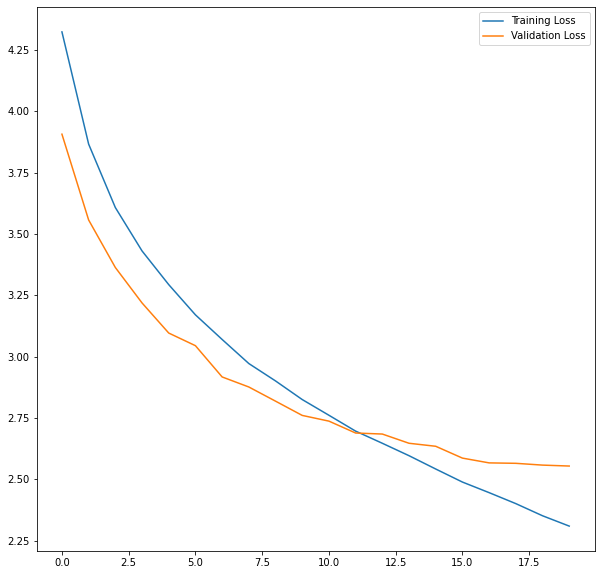

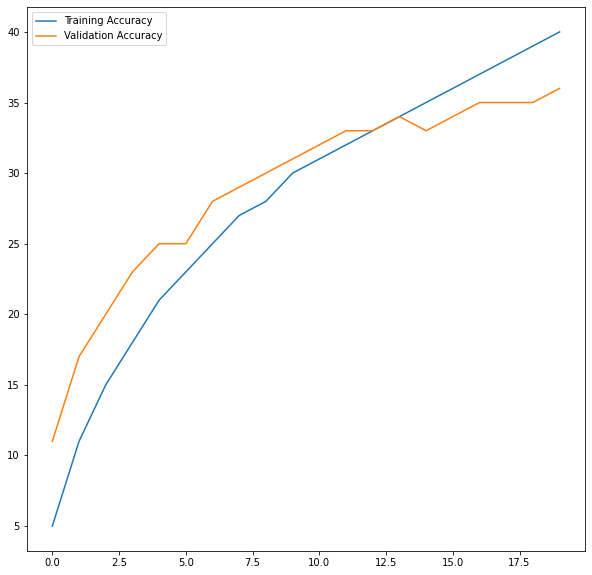

In [0]:
# low learning rate , increase dropout
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr=0.0001, momentum=0.9)
Train_and_Validate(loss_fn, optimizer, trainloader, validloader, len(train), len(validation))

**CNN Model 3 : (1 CNN and 2 FC layer)**

In [0]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3,self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(num_features = 16)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)   #Maxpooling reduces the size by kernel size. 16/2 = 7
        
        #Flatten the feature maps. You have 16 feature maps from cnn3. Each of the feature is of size 7*7 --> 16*7*7 = 784
        self.fc1 = nn.Linear(in_features=16*7*7, out_features=300)   #Flattened image is fed into linear NN and reduced to half size
        self.dropout = nn.Dropout(p=0.6)
        self.fc2 = nn.Linear(in_features=300, out_features=100)
        
    def forward(self,x):
        x = self.maxpool1(F.relu(self.batchnorm1(self.cnn1(x))))
        #print(x.shape)
        x = x.view(-1, 16 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        #x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc2(x)
        return x

net3 = CNN3()

Epoch 1/20, Training Loss: 4.471, Training Accuracy: 3.000, Validation Loss: 4.293, Validation Accuracy: 5.000
Epoch 2/20, Training Loss: 4.137, Training Accuracy: 7.000, Validation Loss: 4.040, Validation Accuracy: 9.000
Epoch 3/20, Training Loss: 3.926, Training Accuracy: 10.000, Validation Loss: 3.873, Validation Accuracy: 11.000
Epoch 4/20, Training Loss: 3.771, Training Accuracy: 13.000, Validation Loss: 3.739, Validation Accuracy: 13.000
Epoch 5/20, Training Loss: 3.642, Training Accuracy: 14.000, Validation Loss: 3.680, Validation Accuracy: 14.000
Epoch 6/20, Training Loss: 3.537, Training Accuracy: 17.000, Validation Loss: 3.563, Validation Accuracy: 16.000
Epoch 7/20, Training Loss: 3.452, Training Accuracy: 18.000, Validation Loss: 3.511, Validation Accuracy: 17.000
Epoch 8/20, Training Loss: 3.360, Training Accuracy: 20.000, Validation Loss: 3.464, Validation Accuracy: 18.000
Epoch 9/20, Training Loss: 3.302, Training Accuracy: 20.000, Validation Loss: 3.401, Validation Accu

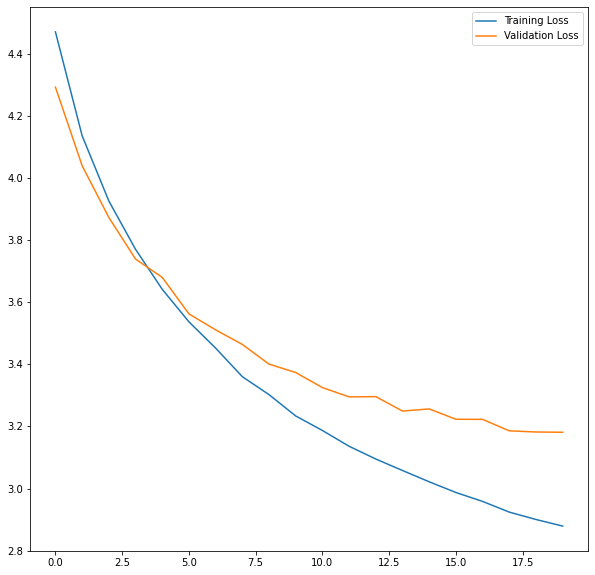

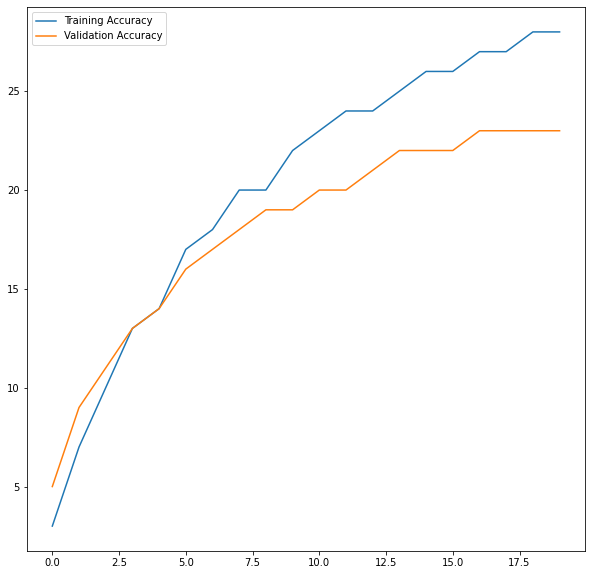

In [82]:
# low learning rate, no dropout
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net3.parameters(), lr=0.0001, momentum=0.9)
Train_and_Validate(loss_fn, optimizer, trainloader, validloader, len(train), len(validation))